# Holiday Hackathon 2020

## GoRemote! x Amazon by Jonathan Ayala and Anna Gauthier

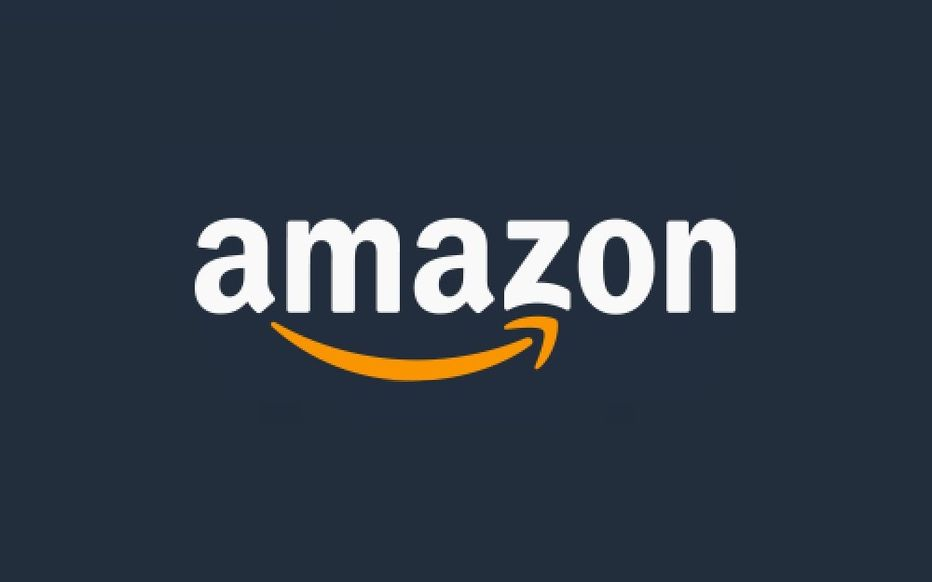

In [17]:
# import nltk
# nltk.download('stopwords')

In [18]:
import numpy as np
import json
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import datetime
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Loading in JSON line file

In [19]:
input_file = 'Office_Products_5.json'

In [20]:
# Load JSON line file into object 
with open(input_file) as f:
    lines = f.read().splitlines()

In [21]:
# Load object into pandas DataFrame
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']

In [22]:
# Decode object into dictionary
import json
df_inter['json_element'].apply(json.loads)

0         {'overall': 4.0, 'verified': True, 'reviewTime...
1         {'overall': 4.0, 'verified': True, 'reviewTime...
2         {'overall': 5.0, 'verified': True, 'reviewTime...
3         {'overall': 5.0, 'verified': True, 'reviewTime...
4         {'overall': 5.0, 'verified': False, 'reviewTim...
                                ...                        
800352    {'overall': 5.0, 'verified': True, 'reviewTime...
800353    {'overall': 5.0, 'verified': True, 'reviewTime...
800354    {'overall': 5.0, 'verified': True, 'reviewTime...
800355    {'overall': 5.0, 'verified': True, 'reviewTime...
800356    {'overall': 4.0, 'verified': True, 'reviewTime...
Name: json_element, Length: 800357, dtype: object

In [23]:
# Normalize data into a flat table
df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))

In [24]:
df_final.head(5)

overall  verified   reviewTime      reviewerID        asin  \
0      4.0      True   11 7, 2017  A2NIJTYWADLK57  0140503528   
1      4.0      True   03 7, 2017  A2827D8EEURMP4  0140503528   
2      5.0      True  06 25, 2016   APB6087F4J09J  0140503528   
3      5.0      True  02 21, 2016  A2DHERRZIPFU7X  0140503528   
4      5.0     False   08 2, 2015   A2XCLJRGFANRC  0140503528   

       reviewerName                                         reviewText  \
0       cotton clay  kids like story BUT while i really wanted a bo...   
1          emankcin  Bought this used and it came in great conditio...   
2     Starbucks Fan  Every story and book about Corduroy is Fantast...   
3  Caitlyn Jacobson  I purchased this book for my first grade class...   
4          E. Ervin  Having spent numerous years in an elementary s...   

                              summary  unixReviewTime style.Format:  ...  \
0  good story, small size book though      1510012800    Board book  ...   
1                                Good      1488844800     Hardcover  ...   
2         Best Books for All Children      1466812800    Board book  ...   
3                     Great for Math!      1456012800     Paperback  ...   
4                       Love Corduroy      1438473600     Hardcover  ...   

  style.style: style.Model: style.Edition: style.Model Number: style.Shape:  \
0          NaN          NaN            NaN                 NaN          NaN   
1          NaN          NaN            NaN                 NaN          NaN   
2          NaN          NaN            NaN                 NaN          NaN   
3          NaN          NaN            NaN                 NaN          NaN   
4          NaN          NaN            NaN                 NaN          NaN   

  style.Platform: style.Material Type: style.Material: style.Flavor:  \
0             NaN                  NaN             NaN           NaN   
1             NaN                  NaN             NaN           NaN   
2             NaN                  NaN             NaN           NaN   
3             NaN                  NaN             NaN           NaN   
4             NaN                  NaN             NaN           NaN   

  style.Gift Amount:  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  

[5 rows x 41 columns]

# Exploratory Data Analysis & Data Cleaning

In [25]:
# df_final.info()

In [26]:
# df_final.describe()

In [27]:
# Reworking unixReviewTime column into new unixReviewTime column
from datetime import datetime

condition = lambda row: datetime.fromtimestamp(row).strftime("%m-%d-%Y")
df_final["unixReviewTime"] = df_final["unixReviewTime"].apply(condition)

In [28]:
# Dropping reviewTime
df_final.drop(columns=['reviewTime'])

overall  verified      reviewerID        asin       reviewerName  \
0           4.0      True  A2NIJTYWADLK57  0140503528        cotton clay   
1           4.0      True  A2827D8EEURMP4  0140503528           emankcin   
2           5.0      True   APB6087F4J09J  0140503528      Starbucks Fan   
3           5.0      True  A2DHERRZIPFU7X  0140503528   Caitlyn Jacobson   
4           5.0     False   A2XCLJRGFANRC  0140503528           E. Ervin   
...         ...       ...             ...         ...                ...   
800352      5.0      True   ACHG5QICJCS1F  B01HHLLLIO               Anky   
800353      5.0      True  A1YB5J8SF6QX3L  B01HHLLLIO                 DM   
800354      5.0      True  A3N4O7L4HBYJX4  B01HHLLLIO  Verdant Treasures   
800355      5.0      True  A2DR3CXSWWLYXY  B01HHLLLIO              C. F.   
800356      4.0      True  A3824BGRMFVT05  B01HINS07G     Tegan M. Reyes   

                                               reviewText  \
0       kids like story BUT while i really wanted a bo...   
1       Bought this used and it came in great conditio...   
2       Every story and book about Corduroy is Fantast...   
3       I purchased this book for my first grade class...   
4       Having spent numerous years in an elementary s...   
...                                                   ...   
800352              Delivered on time and is as expected.   
800353                                      worked great.   
800354  I used to score free UPS 4x6 labels.  The blac...   
800355                                              great   
800356  Struggled finding a sharpener and they didn't ...   

                                      summary unixReviewTime style.Format:  \
0          good story, small size book though     11-06-2017    Board book   
1                                        Good     03-06-2017     Hardcover   
2                 Best Books for All Children     06-24-2016    Board book   
3                             Great for Math!     02-20-2016     Paperback   
4                               Love Corduroy     08-01-2015     Hardcover   
...                                       ...            ...           ...   
800352                                5 stars     09-08-2017           NaN   
800353                             good stuff     06-01-2017           NaN   
800354  Couldn't be happier with these labels     04-28-2017           NaN   
800355                             Five Stars     02-20-2017           NaN   
800356                             Four Stars     01-26-2018           NaN   

       vote  ... style.style: style.Model: style.Edition: style.Model Number:  \
0       NaN  ...          NaN          NaN            NaN                 NaN   
1       NaN  ...          NaN          NaN            NaN                 NaN   
2       NaN  ...          NaN          NaN            NaN                 NaN   
3       NaN  ...          NaN          NaN            NaN                 NaN   
4       NaN  ...          NaN          NaN            NaN                 NaN   
...     ...  ...          ...          ...            ...                 ...   
800352  NaN  ...          NaN          NaN            NaN                 NaN   
800353  NaN  ...          NaN          NaN            NaN                 NaN   
800354  NaN  ...          NaN          NaN            NaN                 NaN   
800355  NaN  ...          NaN          NaN            NaN                 NaN   
800356  NaN  ...          NaN          NaN            NaN                 NaN   

       style.Shape: style.Platform: style.Material Type: style.Material:  \
0               NaN             NaN                  NaN             NaN   
1               NaN             NaN                  NaN             NaN   
2               NaN             NaN                  NaN             NaN   
3               NaN             NaN                  NaN             NaN   
4               NaN             NaN                  NaN             NaN

In [29]:
df_final.shape

(800357, 41)

In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800357 entries, 0 to 800356
Data columns (total 41 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   overall                       800357 non-null  float64
 1   verified                      800357 non-null  bool   
 2   reviewTime                    800357 non-null  object 
 3   reviewerID                    800357 non-null  object 
 4   asin                          800357 non-null  object 
 5   reviewerName                  800217 non-null  object 
 6   reviewText                    800144 non-null  object 
 7   summary                       800228 non-null  object 
 8   unixReviewTime                800357 non-null  object 
 9   style.Format:                 11497 non-null   object 
 10  vote                          88817 non-null   object 
 11  style.Package Quantity:       19083 non-null   object 
 12  image                         11302 non-null

# Verified Purchase Reviews

Per Amazon: https://www.amazon.com/gp/help/customer/display.html?nodeId=202076110

"An 'Amazon Verified Purchase' review means we've verified that the person writing the review purchased the product at Amazon and didn't receive the product at a deep discount."

Not verified? Amazon either can't verify that the product was purchased on Amazon or the customer did not pay a price available to most Amazon shoppers. How many times can I use 'Amazon' in a sentence?

In short, Verified purchase reviews are made to speak to the wider Amazon consumer who pays the standard price for a product, removing any biases to their review via deep discounts.

In [31]:
# How many reviews are not verified? Are they worth including in our analyses?
df_final['verified'].value_counts()

True     710187
False     90170
Name: verified, dtype: int64

In [32]:
# Copy of df_final removing False rows under verified:
df_final = df_final[df_final.verified]
df_final

overall  verified   reviewTime      reviewerID        asin  \
0           4.0      True   11 7, 2017  A2NIJTYWADLK57  0140503528   
1           4.0      True   03 7, 2017  A2827D8EEURMP4  0140503528   
2           5.0      True  06 25, 2016   APB6087F4J09J  0140503528   
3           5.0      True  02 21, 2016  A2DHERRZIPFU7X  0140503528   
5           5.0      True   01 1, 2015  A3JJTLTBCE7T7L  0140503528   
...         ...       ...          ...             ...         ...   
800352      5.0      True   09 9, 2017   ACHG5QICJCS1F  B01HHLLLIO   
800353      5.0      True   06 2, 2017  A1YB5J8SF6QX3L  B01HHLLLIO   
800354      5.0      True  04 29, 2017  A3N4O7L4HBYJX4  B01HHLLLIO   
800355      5.0      True  02 21, 2017  A2DR3CXSWWLYXY  B01HHLLLIO   
800356      4.0      True  01 27, 2018  A3824BGRMFVT05  B01HINS07G   

             reviewerName                                         reviewText  \
0             cotton clay  kids like story BUT while i really wanted a bo...   
1                emankcin  Bought this used and it came in great conditio...   
2           Starbucks Fan  Every story and book about Corduroy is Fantast...   
3        Caitlyn Jacobson  I purchased this book for my first grade class...   
5             Maestra Mam   Corduroy gets a pocket....riveting stuff people.   
...                   ...                                                ...   
800352               Anky              Delivered on time and is as expected.   
800353                 DM                                      worked great.   
800354  Verdant Treasures  I used to score free UPS 4x6 labels.  The blac...   
800355              C. F.                                              great   
800356     Tegan M. Reyes  Struggled finding a sharpener and they didn't ...   

                                      summary unixReviewTime style.Format:  \
0          good story, small size book though     11-06-2017    Board book   
1                                        Good     03-06-2017     Hardcover   
2                 Best Books for All Children     06-24-2016    Board book   
3                             Great for Math!     02-20-2016     Paperback   
5                                  Five Stars     12-31-2014     Paperback   
...                                       ...            ...           ...   
800352                                5 stars     09-08-2017           NaN   
800353                             good stuff     06-01-2017           NaN   
800354  Couldn't be happier with these labels     04-28-2017           NaN   
800355                             Five Stars     02-20-2017           NaN   
800356                             Four Stars     01-26-2018           NaN   

        ... style.style: style.Model: style.Edition: style.Model Number:  \
0       ...          NaN          NaN            NaN                 NaN   
1       ...          NaN          NaN            NaN                 NaN   
2       ...          NaN          NaN            NaN                 NaN   
3       ...          NaN          NaN            NaN                 NaN   
5       ...          NaN          NaN            NaN                 NaN   
...     ...          ...          ...            ...                 ...   
800352  ...          NaN          NaN            NaN                 NaN   
800353  ...          NaN          NaN            NaN                 NaN   
800354  ...          NaN          NaN            NaN                 NaN   
800355  ...          NaN          NaN            NaN                 NaN   
800356  ...          NaN          NaN            NaN                 NaN   

       style.Shape: style.Platform: style.Material Type: style.Material:  \
0               NaN             NaN                  NaN             NaN   
1               NaN             NaN                  NaN             NaN   
2               NaN             NaN                  NaN             NaN   
3               NaN             NaN                 

In [33]:
df_final = df_final[['unixReviewTime', 'overall', 'reviewerID', 'asin', 'summary', 'reviewText']]
df_final

unixReviewTime  overall      reviewerID        asin  \
0          11-06-2017      4.0  A2NIJTYWADLK57  0140503528   
1          03-06-2017      4.0  A2827D8EEURMP4  0140503528   
2          06-24-2016      5.0   APB6087F4J09J  0140503528   
3          02-20-2016      5.0  A2DHERRZIPFU7X  0140503528   
5          12-31-2014      5.0  A3JJTLTBCE7T7L  0140503528   
...               ...      ...             ...         ...   
800352     09-08-2017      5.0   ACHG5QICJCS1F  B01HHLLLIO   
800353     06-01-2017      5.0  A1YB5J8SF6QX3L  B01HHLLLIO   
800354     04-28-2017      5.0  A3N4O7L4HBYJX4  B01HHLLLIO   
800355     02-20-2017      5.0  A2DR3CXSWWLYXY  B01HHLLLIO   
800356     01-26-2018      4.0  A3824BGRMFVT05  B01HINS07G   

                                      summary  \
0          good story, small size book though   
1                                        Good   
2                 Best Books for All Children   
3                             Great for Math!   
5                                  Five Stars   
...                                       ...   
800352                                5 stars   
800353                             good stuff   
800354  Couldn't be happier with these labels   
800355                             Five Stars   
800356                             Four Stars   

                                               reviewText  
0       kids like story BUT while i really wanted a bo...  
1       Bought this used and it came in great conditio...  
2       Every story and book about Corduroy is Fantast...  
3       I purchased this book for my first grade class...  
5        Corduroy gets a pocket....riveting stuff people.  
...                                                   ...  
800352              Delivered on time and is as expected.  
800353                                      worked great.  
800354  I used to score free UPS 4x6 labels.  The blac...  
800355                                              great  
800356  Struggled finding a sharpener and they didn't ...  

[710187 rows x 6 columns]

In [34]:
# Convert unixReviewTime to datetime format, ignore SettingWithCopyWarning
df_final['unixReviewTime'] = pd.to_datetime(df_final['unixReviewTime'])

<ipython-input-34-380b2b93f309>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['unixReviewTime'] = pd.to_datetime(df_final['unixReviewTime'])


In [35]:
# Convert reviewText from object to string format

df_final['reviewText'] = df_final['reviewText'].astype(str)

<ipython-input-35-c49daddb7e42>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['reviewText'] = df_final['reviewText'].astype(str)


In [36]:
# Convert summary from object to string format

df_final['summary'] = df_final['summary'].astype(str)

<ipython-input-36-2e919b377625>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['summary'] = df_final['summary'].astype(str)


In [37]:
# Confirm changes
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710187 entries, 0 to 800356
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unixReviewTime  710187 non-null  datetime64[ns]
 1   overall         710187 non-null  float64       
 2   reviewerID      710187 non-null  object        
 3   asin            710187 non-null  object        
 4   summary         710187 non-null  object        
 5   reviewText      710187 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 37.9+ MB


In [38]:
# Extract year from unixReviewTime for further analysis
df_final['year'] = df_final['unixReviewTime'].dt.year
df_final

<ipython-input-38-0e8646272303>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['year'] = df_final['unixReviewTime'].dt.year


unixReviewTime  overall      reviewerID        asin  \
0          2017-11-06      4.0  A2NIJTYWADLK57  0140503528   
1          2017-03-06      4.0  A2827D8EEURMP4  0140503528   
2          2016-06-24      5.0   APB6087F4J09J  0140503528   
3          2016-02-20      5.0  A2DHERRZIPFU7X  0140503528   
5          2014-12-31      5.0  A3JJTLTBCE7T7L  0140503528   
...               ...      ...             ...         ...   
800352     2017-09-08      5.0   ACHG5QICJCS1F  B01HHLLLIO   
800353     2017-06-01      5.0  A1YB5J8SF6QX3L  B01HHLLLIO   
800354     2017-04-28      5.0  A3N4O7L4HBYJX4  B01HHLLLIO   
800355     2017-02-20      5.0  A2DR3CXSWWLYXY  B01HHLLLIO   
800356     2018-01-26      4.0  A3824BGRMFVT05  B01HINS07G   

                                      summary  \
0          good story, small size book though   
1                                        Good   
2                 Best Books for All Children   
3                             Great for Math!   
5                                  Five Stars   
...                                       ...   
800352                                5 stars   
800353                             good stuff   
800354  Couldn't be happier with these labels   
800355                             Five Stars   
800356                             Four Stars   

                                               reviewText  year  
0       kids like story BUT while i really wanted a bo...  2017  
1       Bought this used and it came in great conditio...  2017  
2       Every story and book about Corduroy is Fantast...  2016  
3       I purchased this book for my first grade class...  2016  
5        Corduroy gets a pocket....riveting stuff people.  2014  
...                                                   ...   ...  
800352              Delivered on time and is as expected.  2017  
800353                                      worked great.  2017  
800354  I used to score free UPS 4x6 labels.  The blac...  2017  
800355                                              great  2017  
800356  Struggled finding a sharpener and they didn't ...  2018  

[710187 rows x 7 columns]

In [39]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710187 entries, 0 to 800356
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unixReviewTime  710187 non-null  datetime64[ns]
 1   overall         710187 non-null  float64       
 2   reviewerID      710187 non-null  object        
 3   asin            710187 non-null  object        
 4   summary         710187 non-null  object        
 5   reviewText      710187 non-null  object        
 6   year            710187 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 43.3+ MB


In [40]:
# How many unique products are there? The answer is 27,630 unique items.
df_final['asin'].nunique()

27630

C:\Users\michaelk\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


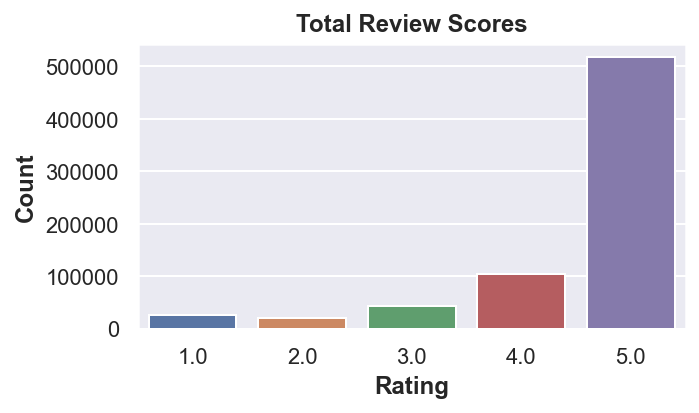

In [107]:
# Countplot of review scores

sns.set(rc={'figure.figsize': (5,3)})
sns.countplot(df_final.overall)
plt.xlabel('Rating', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.title('Total Review Scores', fontweight='bold')
plt.tight_layout()
# plt.savefig('ratings_cntplot.png')

Text(0.5, 1.0, 'Average Product Review Score by Year')

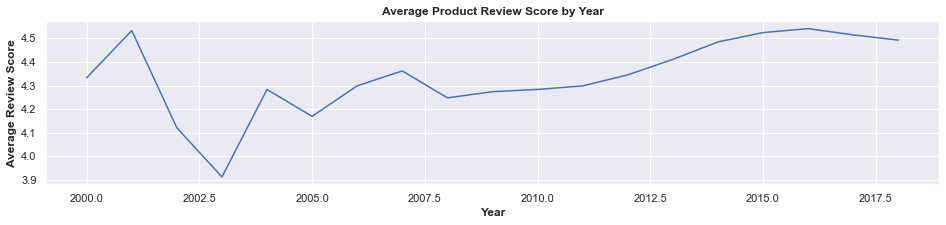

In [42]:
# Average review score over time? Have review scores increased (maybe feedback has helped a lot?)?

avg_score = df_final.groupby(['year'])['overall'].mean().reset_index()
avg_score

# Graph it. They seem really close.

sns.set(rc={'figure.figsize': (16,3)})
ax = sns.lineplot(x = 'year', y = 'overall', data = avg_score)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Average Review Score', fontweight='bold')
plt.title('Average Product Review Score by Year', fontweight='bold')

In [43]:
# Number of reviews over time? Do more people want their voices heard over time (increase in accessibility perhaps)?
count_revs = df_final.groupby(['year'])['asin'].count().reset_index()
count_revs

year    asin
0   2000      15
1   2001      15
2   2002      33
3   2003      46
4   2004      67
5   2005     165
6   2006     321
7   2007    1027
8   2008    1862
9   2009    3253
10  2010    4705
11  2011    8323
12  2012   16605
13  2013   48953
14  2014   94074
15  2015  163421
16  2016  181325
17  2017  131354
18  2018   54623

Text(0.5, 1.0, 'Total Product Reviews By Year')

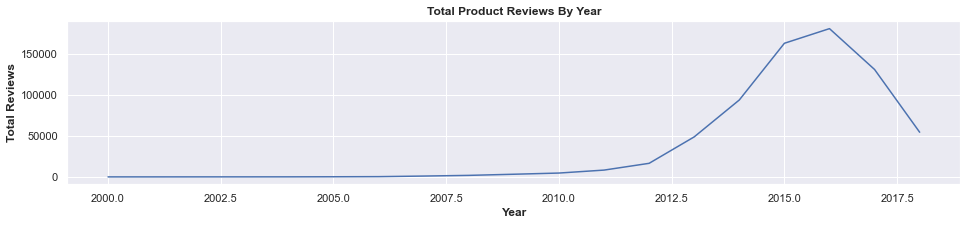

In [44]:
# Line graph reflecting counts of reviews over time
sns.set(rc={'figure.figsize': (16,3)})
ax = sns.lineplot(x = 'year', y = 'asin', data = count_revs)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Total Reviews', fontweight='bold')
plt.title('Total Product Reviews By Year', fontweight='bold')

In [45]:
# Number of unique product offerings by year
unique_yr = df_final.groupby('year')['asin'].nunique().reset_index()
unique_yr

year   asin
0   2000     10
1   2001     15
2   2002     29
3   2003     35
4   2004     54
5   2005     99
6   2006    185
7   2007    461
8   2008    823
9   2009   1433
10  2010   2115
11  2011   3450
12  2012   5717
13  2013  10085
14  2014  14479
15  2015  19783
16  2016  22315
17  2017  19273
18  2018  12929

Text(0.5, 1.0, 'Unique Products Reviewed by Year')

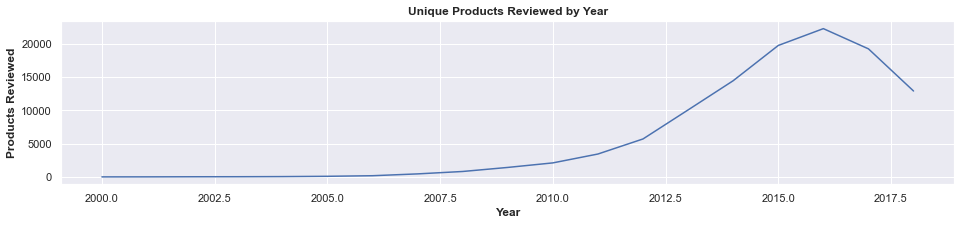

In [46]:
# Lineplot unique products by year

sns.set(rc={'figure.figsize': (16,3)})
ax = sns.lineplot(x = 'year', y = 'asin', data = unique_yr)
plt.xlabel('Year', fontweight='bold')
plt.ylabel('Products Reviewed', fontweight='bold')
plt.title('Unique Products Reviewed by Year', fontweight='bold')

In [47]:
# Which is the date range for this data set?

In [48]:
print (df_final.unixReviewTime.min())

2000-05-06 00:00:00


In [49]:
print (df_final.unixReviewTime.max())

2018-10-01 00:00:00


# Natural Language Processing

# Word Clouds

## Top three products highest rated and most reviewed products

In [50]:
# df_final

In [51]:
high_rated = df_final[(df_final['overall'] == 5.0)]
high_rated

unixReviewTime  overall      reviewerID        asin  \
2          2016-06-24      5.0   APB6087F4J09J  0140503528   
3          2016-02-20      5.0  A2DHERRZIPFU7X  0140503528   
5          2014-12-31      5.0  A3JJTLTBCE7T7L  0140503528   
6          2014-12-14      5.0  A1HFSC0ZQDUP6R  0140503528   
8          2013-08-16      5.0  A3MBBC80DD58HM  0140503528   
...               ...      ...             ...         ...   
800351     2018-07-09      5.0  A2XCUHLNW5Q496  B01HH8E2QA   
800352     2017-09-08      5.0   ACHG5QICJCS1F  B01HHLLLIO   
800353     2017-06-01      5.0  A1YB5J8SF6QX3L  B01HHLLLIO   
800354     2017-04-28      5.0  A3N4O7L4HBYJX4  B01HHLLLIO   
800355     2017-02-20      5.0  A2DR3CXSWWLYXY  B01HHLLLIO   

                                      summary  \
2                 Best Books for All Children   
3                             Great for Math!   
5                                  Five Stars   
6                         Thank you very much   
8                                    Love it!   
...                                       ...   
800351                             Five Stars   
800352                                5 stars   
800353                             good stuff   
800354  Couldn't be happier with these labels   
800355                             Five Stars   

                                               reviewText  year  
2       Every story and book about Corduroy is Fantast...  2016  
3       I purchased this book for my first grade class...  2016  
5        Corduroy gets a pocket....riveting stuff people.  2014  
6                                          Love this book  2014  
8       This is a lovely gentle simple story of love a...  2013  
...                                                   ...   ...  
800351  Great value, packaged well, perfect for our of...  2018  
800352              Delivered on time and is as expected.  2017  
800353                                      worked great.  2017  
800354  I used to score free UPS 4x6 labels.  The blac...  2017  
800355                                              great  2017  

[517481 rows x 7 columns]

In [52]:
high_rated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 517481 entries, 2 to 800355
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unixReviewTime  517481 non-null  datetime64[ns]
 1   overall         517481 non-null  float64       
 2   reviewerID      517481 non-null  object        
 3   asin            517481 non-null  object        
 4   summary         517481 non-null  object        
 5   reviewText      517481 non-null  object        
 6   year            517481 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 31.6+ MB


In [53]:
most_rated = high_rated.groupby('asin')['reviewerID'].count().reset_index()
most_rated.sort_values('reviewerID', ascending=False)

asin  reviewerID
5899   B0010JEJPC        1804
1346   B00006IEEV        1776
1529   B00006IFEU        1508
14772  B00A89YZ6S        1502
1616   B00006JNJD        1390
...           ...         ...
22234  B00VJAI6BA           1
6254   B0013CFHPM           1
10608  B003UFU76Y           1
22270  B00VS69F5G           1
11269  B004HS6GY0           1

[27253 rows x 2 columns]

## Text length for each product (reviews)

In [54]:
# Function returns length of text for each review
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [55]:
# Apply function to df_final
df_final['length'] = df_final['reviewText'].apply(length)
df_final.head(10)

<ipython-input-55-d7154112242d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['length'] = df_final['reviewText'].apply(length)


unixReviewTime  overall      reviewerID        asin  \
0      2017-11-06      4.0  A2NIJTYWADLK57  0140503528   
1      2017-03-06      4.0  A2827D8EEURMP4  0140503528   
2      2016-06-24      5.0   APB6087F4J09J  0140503528   
3      2016-02-20      5.0  A2DHERRZIPFU7X  0140503528   
5      2014-12-31      5.0  A3JJTLTBCE7T7L  0140503528   
6      2014-12-14      5.0  A1HFSC0ZQDUP6R  0140503528   
8      2013-08-16      5.0  A3MBBC80DD58HM  0140503528   
9      2016-11-13      5.0  A3F5YTCGCUS27L  0310432065   
10     2016-10-26      5.0   AN2FZ6SBNYDDQ  0310432065   
11     2016-08-03      5.0  A2W0001LSKE9YB  0310432065   

                               summary  \
0   good story, small size book though   
1                                 Good   
2          Best Books for All Children   
3                      Great for Math!   
5                           Five Stars   
6                  Thank you very much   
8                             Love it!   
9                           Five Stars   
10                          Five Stars   
11                          Five Stars   

                                           reviewText  year  length  
0   kids like story BUT while i really wanted a bo...  2017      94  
1   Bought this used and it came in great conditio...  2017     220  
2   Every story and book about Corduroy is Fantast...  2016     267  
3   I purchased this book for my first grade class...  2016     511  
5    Corduroy gets a pocket....riveting stuff people.  2014      48  
6                                      Love this book  2014      14  
8   This is a lovely gentle simple story of love a...  2013     325  
9                                       What I needed  2016      13  
10  perfect for my larger bible NIV Zondervan stud...  2016      54  
11                                  Bought for a gift  2016      17

In [56]:
# Separate the top rated into three different DataFrames, but inclusive of all ratings so as not to explore with bias.

In [57]:
# Extract data to perform even more specific NLP analyses
laminator_data = df_final[df_final['asin'] == 'B0010JEJPC']
prismacolor_data = df_final[df_final['asin'] == 'B00006IEEV']
sharpie_data = df_final[df_final['asin'] == 'B00006IFEU']

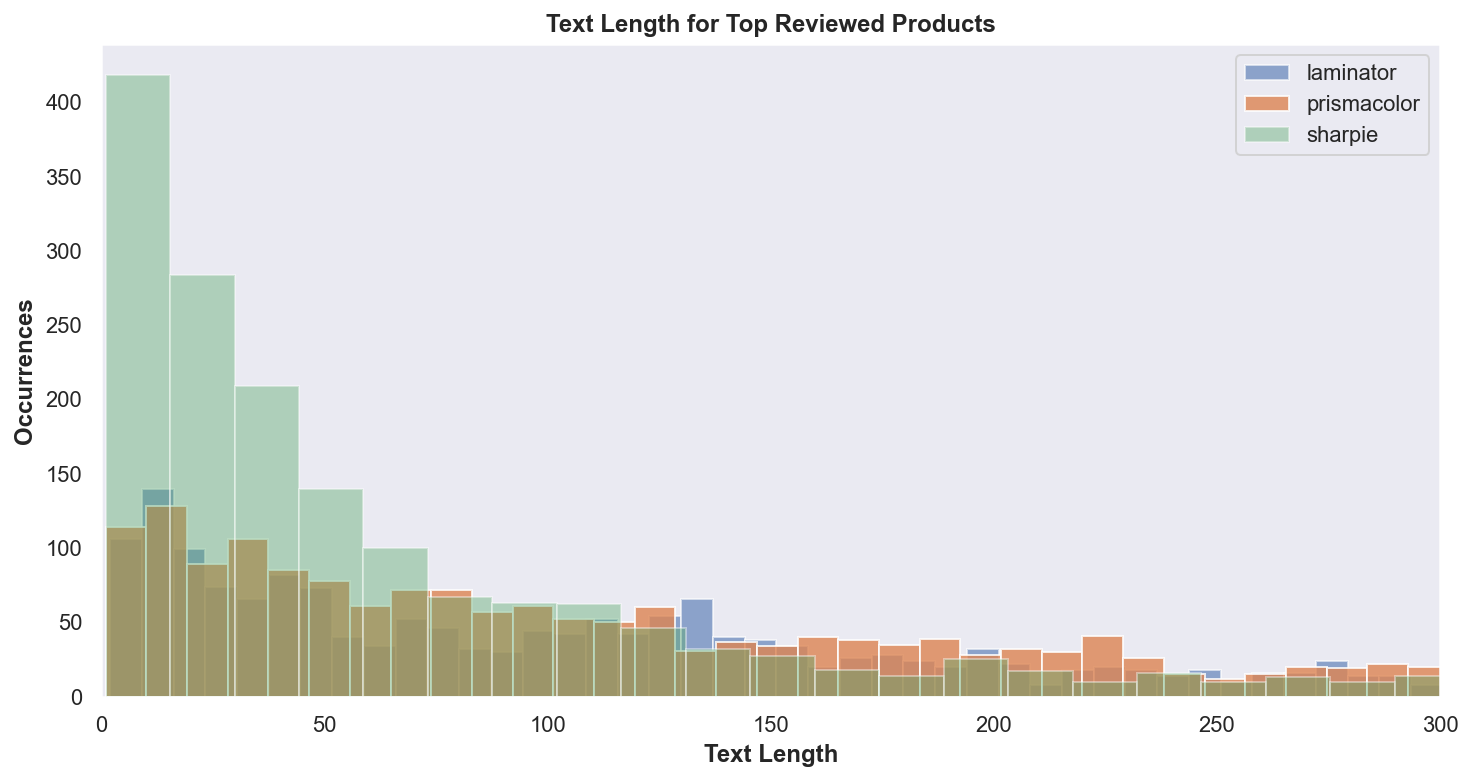

<Figure size 864x432 with 0 Axes>

In [117]:
# Histogram of text length for each item

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 500
plt.hist(laminator_data['length'], alpha = 0.6, bins=bins, label='laminator')
plt.hist(prismacolor_data['length'], alpha = 0.8, bins=bins, label='prismacolor')
plt.hist(sharpie_data['length'], alpha = 0.4, bins=bins, label='sharpie')
plt.xlabel('Text Length', fontweight='bold')
plt.ylabel('Occurrences', fontweight='bold')
plt.title('Text Length for Top Reviewed Products', fontweight='bold')
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.grid()
plt.show()

plt.tight_layout()
plt.savefig('Text Length for Top Reviewed Products.png')

## Scotch Thermal Laminator Word Cloud

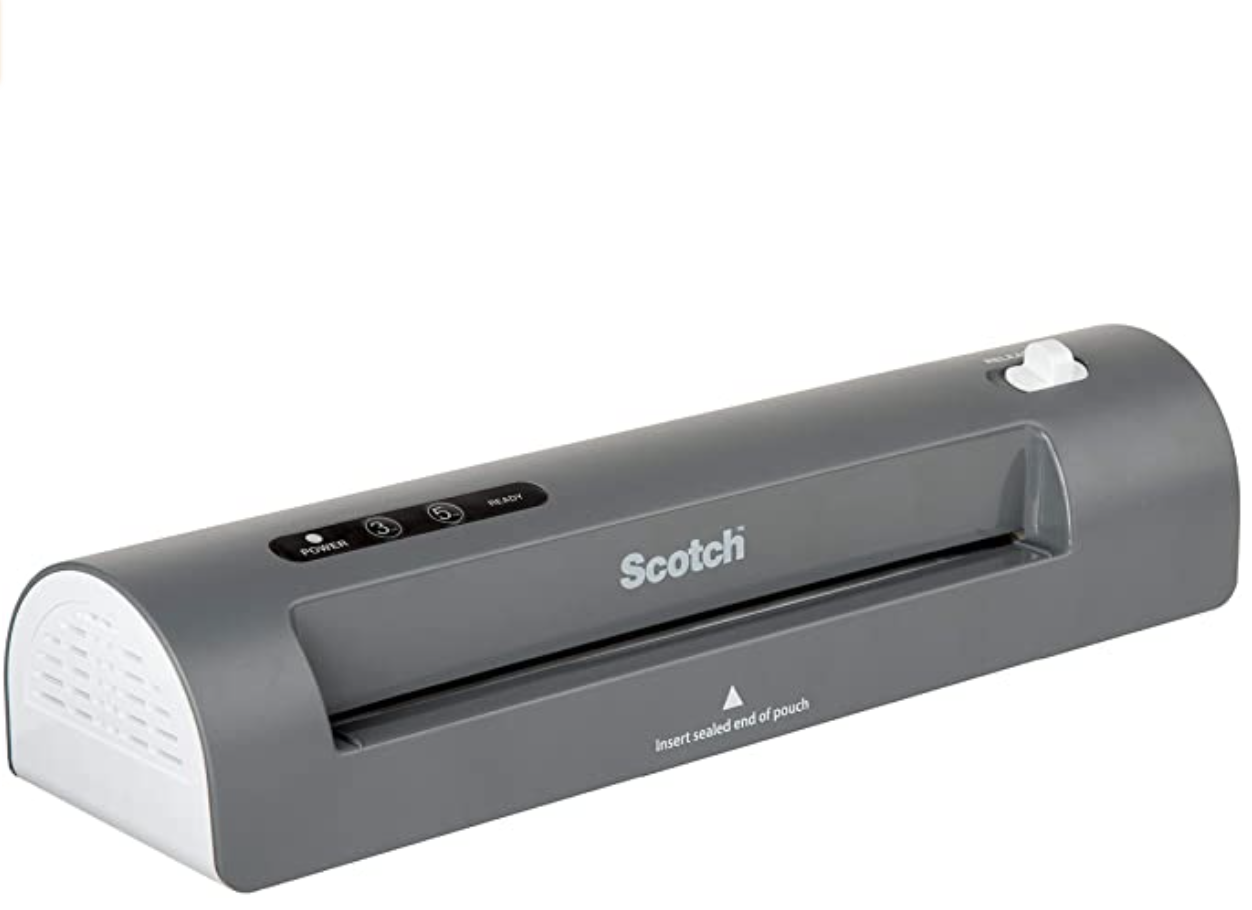

In [59]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [60]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [61]:
laminator_data['reviewText']= laminator_data['reviewText'].astype(str)

<ipython-input-61-578ae7044abe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laminator_data['reviewText']= laminator_data['reviewText'].astype(str)


In [62]:
laminator_data['reviewText'] = laminator_data['reviewText'].apply(remove_punctuation)
laminator_data.head(1)

<ipython-input-62-77c4448e74cd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laminator_data['reviewText'] = laminator_data['reviewText'].apply(remove_punctuation)


unixReviewTime  overall      reviewerID        asin     summary  \
222764     2018-04-24      5.0  A3CTXC2N7N28OF  B0010JEJPC  Five Stars   

       reviewText  year  length  
222764   It works  2018       9

In [63]:
import nltk
# nltk.download('stopwords')

In [64]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [65]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


In [66]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [67]:
laminator_data['reviewText'] = laminator_data['reviewText'].apply(stopwords)
laminator_data.head(1)

<ipython-input-67-c7f3076f55eb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  laminator_data['reviewText'] = laminator_data['reviewText'].apply(stopwords)


unixReviewTime  overall      reviewerID        asin     summary  \
222764     2018-04-24      5.0  A3CTXC2N7N28OF  B0010JEJPC  Five Stars   

       reviewText  year  length  
222764      works  2018       9

In [68]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [69]:
# ! pip install wordcloud

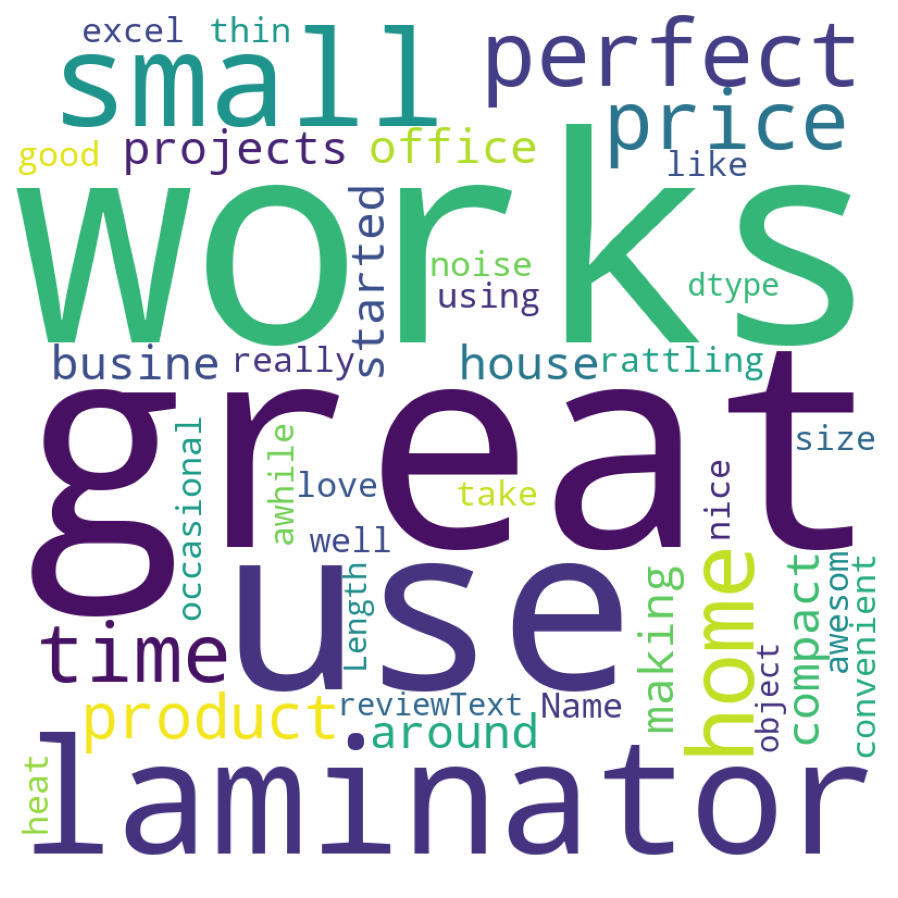

In [70]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = sw, max_words = 1000
                      , min_font_size = 20).generate(str(laminator_data['reviewText']))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Prismacolor Pencil Word Cloud

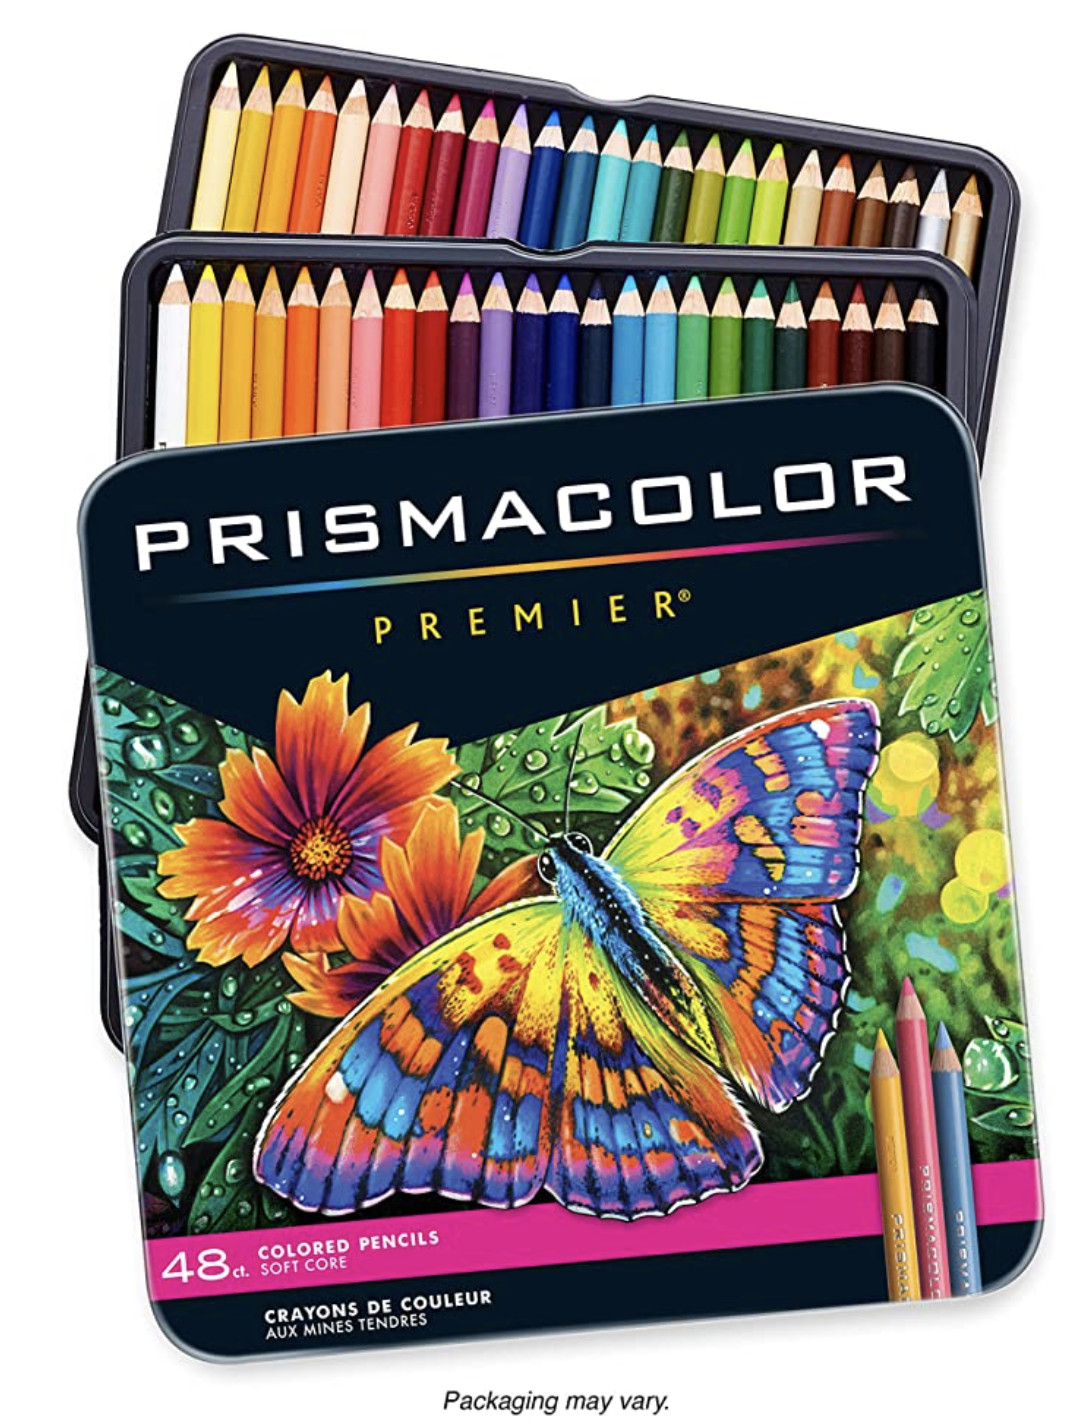

In [71]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [72]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [73]:
prismacolor_data['reviewText']= prismacolor_data['reviewText'].astype(str)

<ipython-input-73-0dc214f46ef0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prismacolor_data['reviewText']= prismacolor_data['reviewText'].astype(str)


In [74]:
prismacolor_data['reviewText'] = prismacolor_data['reviewText'].apply(remove_punctuation)
prismacolor_data.head(1)

<ipython-input-74-56ccd91ca0ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prismacolor_data['reviewText'] = prismacolor_data['reviewText'].apply(remove_punctuation)


unixReviewTime  overall      reviewerID        asin     summary  \
53711     2018-05-14      5.0  A1O44FFI6QPRU2  B00006IEEV  Five Stars   

         reviewText  year  length  
53711  Great thanks  2018      13

In [75]:
import nltk
# nltk.download('stopwords')

In [76]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [77]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


In [78]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [79]:
prismacolor_data['reviewText'] = prismacolor_data['reviewText'].apply(stopwords)
prismacolor_data.head(1)

<ipython-input-79-cd187eae29e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prismacolor_data['reviewText'] = prismacolor_data['reviewText'].apply(stopwords)


unixReviewTime  overall      reviewerID        asin     summary  \
53711     2018-05-14      5.0  A1O44FFI6QPRU2  B00006IEEV  Five Stars   

         reviewText  year  length  
53711  great thanks  2018      13

In [80]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [81]:
# ! pip install wordcloud

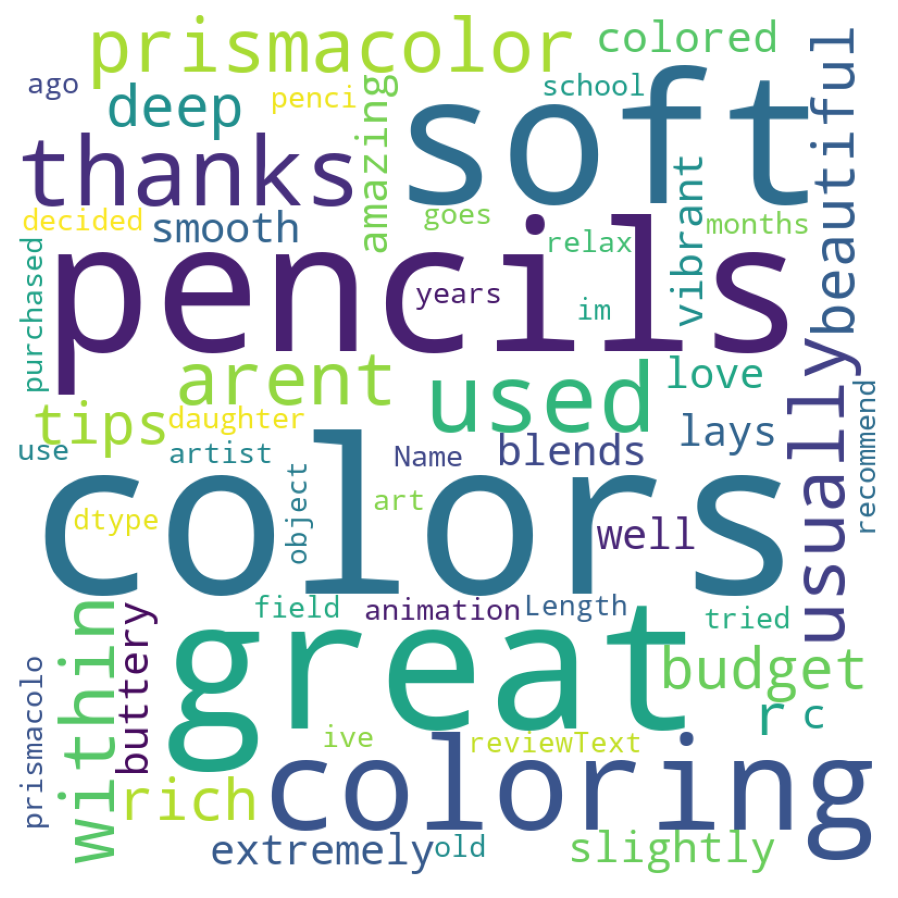

In [82]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = sw, max_words = 1000
                      , min_font_size = 20).generate(str(prismacolor_data['reviewText']))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Sharpie 12-pack Word Cloud

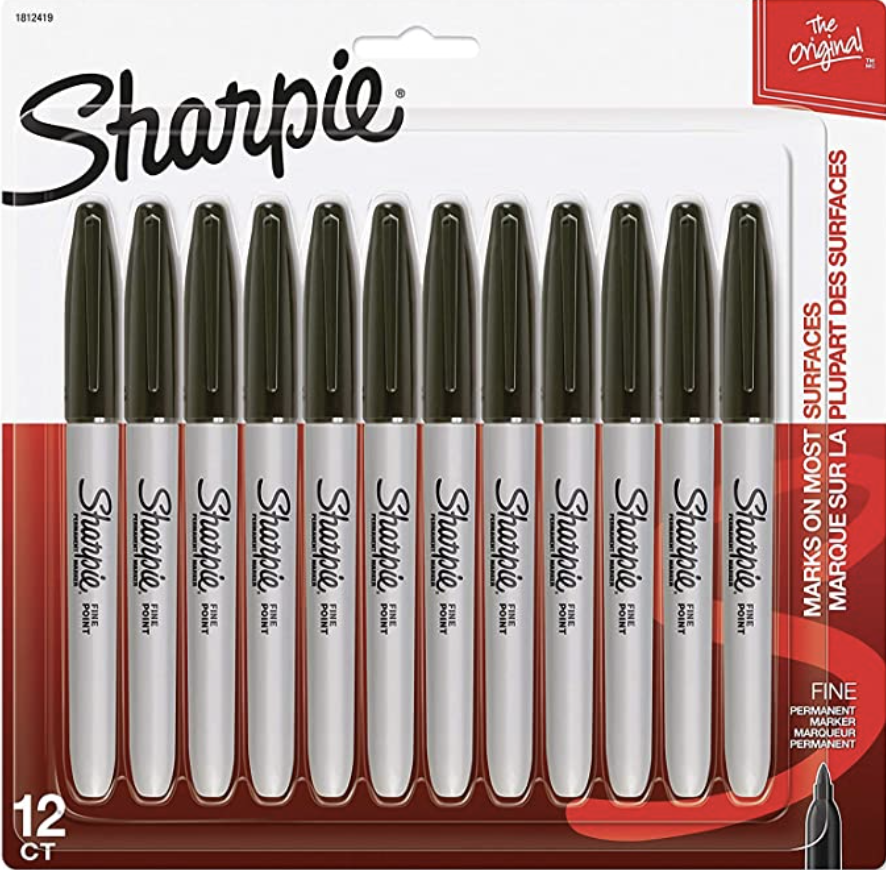

In [83]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [84]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [85]:
sharpie_data['reviewText']= sharpie_data['reviewText'].astype(str)

<ipython-input-85-7b358cd9b825>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpie_data['reviewText']= sharpie_data['reviewText'].astype(str)


In [86]:
sharpie_data['reviewText'] = sharpie_data['reviewText'].apply(remove_punctuation)
sharpie_data.head(1)

<ipython-input-86-1a83ae70f0df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpie_data['reviewText'] = sharpie_data['reviewText'].apply(remove_punctuation)


unixReviewTime  overall      reviewerID        asin  \
63734     2018-05-12      5.0  A2VK0FJCMZBZY6  B00006IFEU   

                            summary  \
63734  Good price for this product.   

                                         reviewText  year  length  
63734  Arrived quickly  Good price for this product  2018      46

In [87]:
import nltk
# nltk.download('stopwords')

In [88]:
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [89]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


In [90]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [91]:
sharpie_data['reviewText'] = sharpie_data['reviewText'].apply(stopwords)
sharpie_data.head(1)

<ipython-input-91-8f8d89365836>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sharpie_data['reviewText'] = sharpie_data['reviewText'].apply(stopwords)


unixReviewTime  overall      reviewerID        asin  \
63734     2018-05-12      5.0  A2VK0FJCMZBZY6  B00006IFEU   

                            summary                          reviewText  year  \
63734  Good price for this product.  arrived quickly good price product  2018   

       length  
63734      46

In [92]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [93]:
# ! pip install wordcloud

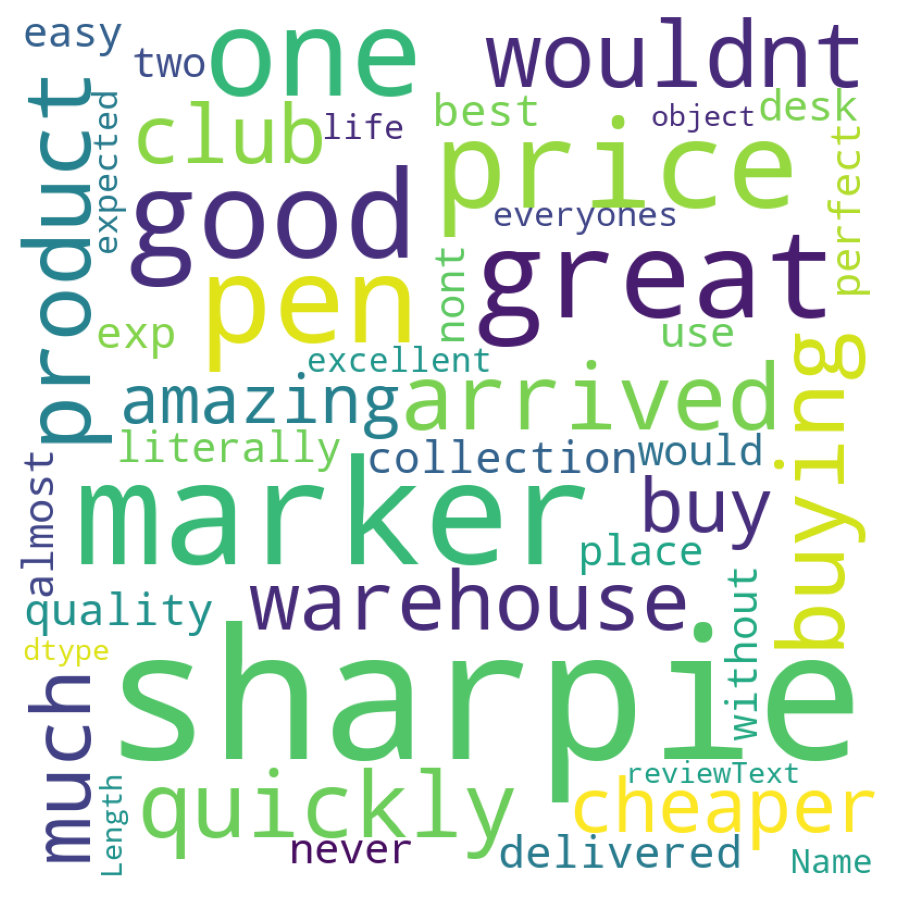

In [94]:
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords = sw, max_words = 1000
                      , min_font_size = 20).generate(str(sharpie_data['reviewText']))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Sentiment Analysis

Knowing the most frequent words used in reviews is helpful, but what about the emotions, mood, or opinion behind these words?

In [95]:
import nltk
# nltk.download('wordnet')

## Polarity

Polarity is a float between [-1, 1], where 1 is a positive statement, and -1 is a negative statement.

In [96]:
# high_rated is derived from df_finalc

In [97]:
# Filter df_finalc df to show only relevant products
df_final_sa = df_finalc[(df_finalc['asin'] == 'B0010JEJPC') | (df_finalc['asin'] == 'B00006IEEV') | (df_finalc['asin'] == 'B00006IFEU')]
df_final_sa

overall  verified   reviewTime      reviewerID        asin  \
53711       5.0      True  05 15, 2018  A1O44FFI6QPRU2  B00006IEEV   
53766       5.0      True  05 13, 2018  A2MUKNK3NNDQXJ  B00006IEEV   
53767       5.0      True  05 12, 2018   AMKX54XQ6637V  B00006IEEV   
53817       5.0      True   05 9, 2018   AI1VKT4EGDAU0  B00006IEEV   
53843       5.0      True   05 8, 2018  A2MO0GTIK8F9VQ  B00006IEEV   
...         ...       ...          ...             ...         ...   
746530      5.0      True  05 17, 2018  A3PW4WQ3AKB51A  B00006IEEV   
746968      5.0      True  05 15, 2018  A2311LU9GNI8A9  B00006IFEU   
746969      5.0      True  05 15, 2018  A3OPM9I91CRD4Z  B00006IFEU   
757282      5.0      True  05 23, 2018   AJATVO0NB62UR  B0010JEJPC   
757283      5.0      True   05 8, 2018  A1GOUJPVCY9XKO  B0010JEJPC   

             reviewerName                                         reviewText  \
53711          M. Claeson                                      Great thanks!   
53766           Jeanne A.  I had not used Prismacolor before as they aren...   
53767                 RJG  Beautiful colors! Rich and deep. The tips are ...   
53817            Patricia  Amazing colored pencils. They are so soft and ...   
53843      Melody Trotter  Lays down buttery smooth and blends well. I lo...   
...                   ...                                                ...   
746530    Amazon Customer                  Recommend these coloring pencils.   
746968               lynn                                        as expected   
746969  Gerald R. Dudgeon                                 Excellent markers.   
757282   Donique Oliveira    Love this laminator. So perfect and convenient.   
757283      Wayne Brennan                           Works great.\nnice size.   

                                summary unixReviewTime style.Format:  ...  \
53711                        Five Stars     05-14-2018           NaN  ...   
53766                      I love them!     05-12-2018           NaN  ...   
53767   Beautiful colors! Rich and deep     05-11-2018           NaN  ...   
53817          Amazing set for artists.     05-08-2018           NaN  ...   
53843        Best for price and quality     05-07-2018           NaN  ...   
...                                 ...            ...           ...  ...   
746530                       Five Stars     05-16-2018           NaN  ...   
746968                       Five Stars     05-14-2018           NaN  ...   
746969                       Five Stars     05-14-2018           NaN  ...   
757282                       Five Stars     05-22-2018           NaN  ...   
757283                  Would buy again     05-07-2018           NaN  ...   

       style.style: style.Model: style.Edition: style.Model Number:  \
53711           NaN          NaN            NaN                 NaN   
53766           NaN          NaN            NaN                 NaN   
53767           NaN          NaN            NaN                 NaN   
53817           NaN          NaN            NaN                 NaN   
53843           NaN          NaN            NaN                 NaN   
...             ...          ...            ...                 ...   
746530          NaN          NaN            NaN                 NaN   
746968          NaN          NaN            NaN                 NaN   
746969          NaN          NaN            NaN                 NaN   
757282          NaN          NaN            NaN                 NaN   
757283          NaN          NaN            NaN                 NaN   

       style.Shape: style.Platform: style.Material Type: style.Material:  \
53711           NaN             NaN                  NaN             NaN   
53766           NaN             NaN                  NaN             NaN   
53767           NaN             NaN                  NaN             NaN   
53817           NaN             NaN                  NaN             NaN   
53843           NaN             NaN             

In [98]:
# So there IS at least a slight spread for ratings, but still overwhelmingly positive.
curiosity = df_final_sa.groupby('overall')['reviewerID'].count().reset_index()
curiosity

overall  reviewerID
0      1.0          92
1      2.0          64
2      3.0         151
3      4.0         600
4      5.0        5088

In [99]:
# conda install -c conda-forge textblob

In [100]:
# Create quick lambda functions to find the polarity of each review for the relevant products

from textblob import TextBlob
df_final_sa['reviewText']= df_final_sa['reviewText'].astype(str) #Make sure about the correct data type
pol = lambda x: TextBlob(x).sentiment.polarity
df_final_sa['polarity'] = df_final_sa['reviewText'].apply(pol) # depending on the size of your data, this step may take some time.
import matplotlib.pyplot as plt
import seaborn as sns

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df_final_sa.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity', fontweight='bold')
plt.ylabel('Number of Reviews', fontweight='bold')
plt.title('Histogram of Polarity Score', fontweight='bold')
plt.show();

ModuleNotFoundError: No module named 'textblob'

This figure reflects the polarity score for reviews of the relevant products. Most are interpreted as neutral to positive statements.

## Subjectivity

Subjectivity is used to determine whether a sentence (or review) expresses an opinion or not. It's a float in the range of [0,1]. If it's closer to 0, it is more of a factual statement. As it increases, it becomes more of an opinion.

In [ ]:
# Creating subjectivity scores

sub = lambda x: TextBlob(x).sentiment.subjectivity
df_final_sa['subjectivity'] = df_final_sa['reviewText'].apply(sub)
df_final_sa.sample(10)

In [ ]:
# Distribution of subjectivity score

# Density Plot and Histogram of subjectivity

plt.figure(figsize=(10,5))
sns.distplot(df_final_sa['subjectivity'], hist=True, kde=True,
bins=int(30), color = 'darkblue',
hist_kws={'edgecolor':'black'},
kde_kws={'linewidth': 4})
plt.xlim([-0.001,1.001])
plt.xlabel('Subjectivity', fontsize=13, fontweight='bold')
plt.ylabel('Frequency', fontsize=13, fontweight='bold')
plt.title('Distribution of Subjectivity Score', fontsize=15, fontweight='bold')

# Conclusions

GoRemote!'s goal is to provide the best product bundles to our subscribers to fill their remote working needs, categorically. We uncovered three of the top office products by exploring those with the most five-star reviews.

We wanted to see what customers were saying about these products to build certainty on whether we believed they were worth providing to our subscribers. Using NLP, we created word clouds (tag clouds) for each product to visualize review text data, and explore the importance of each word according to its frequency in reviews.

Once we knew what people were saying most about these products, we wanted to analyze the emotion and mood being conveyed by the words.

We performed sentiment analysis to examine polarity and subjectivity in the reviews. We discovered that most reviews are neutral to positive in their tone. Reviews typically blend fact and opinion to convey their feelings on the product, but more reviews are factual than opinionated.

Taking our sentiment analysis and word clouds into consideration, we are confident that our subscribers will enjoy the products we've selected.

# Next steps/suggestions

Suggestion: Many products are not assigned a product category. This should become mandatory to improve analyses.

Next Step: Explore transaction data to further understand user behavior. Are customers more inclined to chase products      with high ratings, or better reviews?

Next Step: Observe impact of text length on NLP techniques. Would a shorter review significantly skew polarity and subjectivity?

Moving Forward: Create a predictive model using logistic regression to explore which aspects of a product page most highly influence purchases.

Moving Forward: Create a model to automate sentiment analysis for quick and efficient insights on what people are saying/feeling about the product, from moment-to-moment.